 ## <center> MNIST image classifiaction </center>
 
Table of Contents:
1. [Data input and check](#data_input)
2. [Feature engineering](#features)
3. [LDA](#LDA)
4. [Neural Nets](#tf)
5. [Comparison of models](#results)

In this notebook we will explore the MNIST dataset. We will try to apply different machine learning techniques to classify the images of hadwritten digits from the standard publicly available dataset.

First import some useful packages for the analysis.

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

import scipy

<a id = "data_input"></a>
### <center> Data input and check </center>


First we read the MNIST data from the file. Each image is represented as an array of integers from [0..255] of length 785. First number is the digit label of the instance. The rest representsa 28x28 image in grayscale.

In [2]:
train_data = pd.read_csv("train.csv")

Let's look at some basics of the data:

In [3]:
train_data.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first column indeed represents the label of the picture. We check that all labels are in the correct range:

In [4]:
train_data["label"].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

We see that indeed there are labels from 0 to 9 and also notice that the distribution between classes is almost uniform.

Extract the data and the labels:

In [5]:
X_data = train_data.iloc[:,1:]
Y_data = train_data.iloc[:,0:1]

Split the data into training and validation sets. The validation set is used to choose the parameters of the models. We will use kaggle test set (public leaderboard) for MNIST to test the models.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid= train_test_split(X_data, Y_data, test_size=0.3, random_state=0)

First we will try one of the basic linear methods - Linear Discriminant Analysis.

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, Y_train.as_matrix().T.ravel())

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [10]:
LDA_prediction = LDA_model.predict(X_valid)

This is a function that converts a 784-dimnetional vector into a picture. When plotting prediction results we will use blue colors for correct and red for incorrect guesses.

In [11]:
def to_pic(vec, **kwargs):
    img = vec.as_matrix().reshape((28,28))
    plt.imshow(img)
    plt.set_cmap("Blues")
    if prediction != "correct": plt.set_cmap('Reds')
    plt.axis("off")
    plt.show()

Now we can look at some predictions.

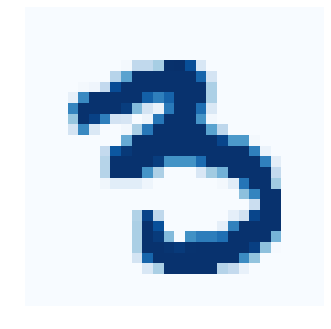

Prediction:  3


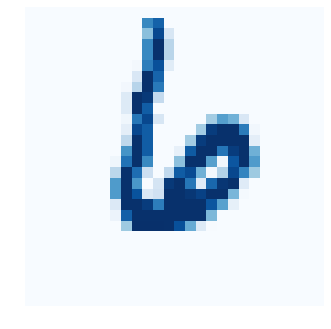

Prediction:  6


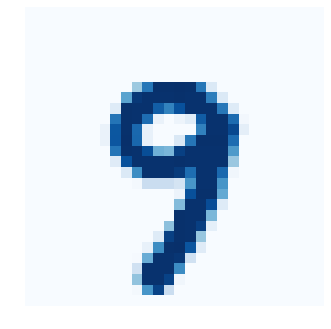

Prediction:  9


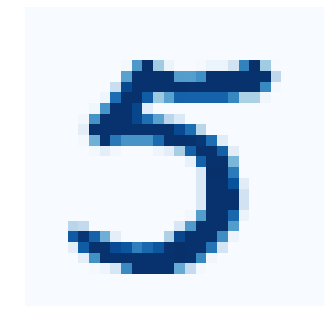

Prediction:  5


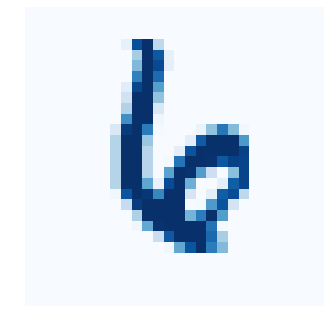

Prediction:  6


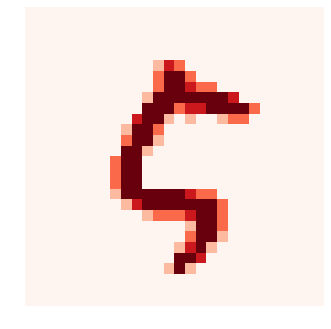

Prediction:  0


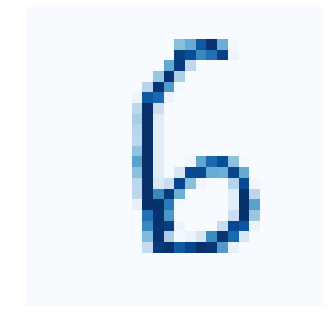

Prediction:  6


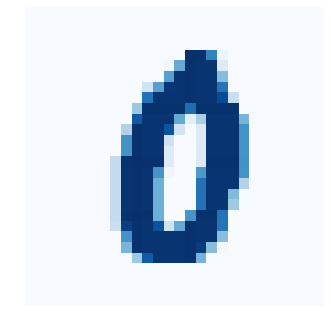

Prediction:  0


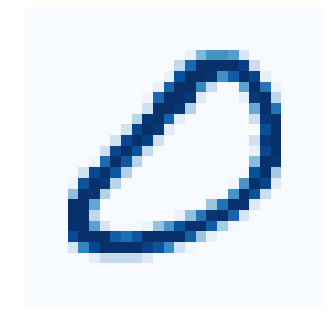

Prediction:  0


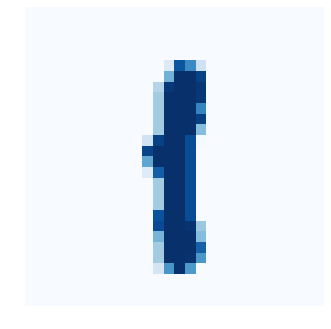

Prediction:  1


In [12]:
for n in range(10):
    prediction = "incorrect"
    if LDA_prediction[n] == Y_valid.iloc[n,0]: prediction = "correct"
    to_pic(X_valid.iloc[n,:], prediction = prediction)
    print("Prediction: ", LDA_prediction[n])

We see that the predictions are quite accurate. In terms of actual numbers, the accuracy of LDA on the raw data is 

In [14]:
LDA_model.score(X_valid, Y_valid)

0.86857142857142855

Let's see if accuracy depend on the random split. Basically we do k-fold cross-validation with random splits.

In [16]:
k_folds = 10
for i in range(k_folds):
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_data, Y_data, test_size=0.3, random_state=i)
    LDA_model.fit(X_train, Y_train.as_matrix().T.ravel())
    print(LDA_model.score(X_valid, Y_valid))

TypeError: score() got an unexpected keyword argument 'njobs'

Do the same with sklearn cross-validation package.

In [18]:
from sklearn.model_selection import cross_val_score
Y_data_reshaped =  Y_data.as_matrix().reshape((Y_data.shape[0],))

scores = cross_val_score(LDA_model, X_data, Y_data_reshaped, cv = 5, n_jobs = -1)
print(scores)

[ 0.86424747  0.8651672   0.86450768  0.86078361  0.86767508]


Both give us the the accuracy of LDA models about 86%.

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
LogRegr_model = LogisticRegression(penalty = "l2")

In [ ]:
scores = cross_val_score(LogRegr_model, X_data, Y_data_reshaped, cv = 5, n_jobs = 3)

print(scores)

## <center> Feature Engeneering </center>
<a id='feat_eng'> </a>

Let's try to come up with  some nontrivial features and see if they can improve the prediction accuracy or may even be used alone. 

First we will treat each picture as a probability density distribution (normalize) and take marginal one-dimensional distributions. The features are going to be statistics of these distributions: moments, quantiles. 

We can also consider marginal distributions just as functions of one variable and extract some features from them. For example, count local minima/ maxima, calculate moments w.r.t. centroids.

In [69]:
# count the number of local maximums in array
def loc_max_count(a): 
    ans = 0
    for i in range(1,len(a)-1):
        if a[i] > a[i+1] and a[i] > a[i-1]: ans += 1
    return(ans)

Now we implemet a function that given a one vector from data set returns a tuple of features. Then we will try to classify images from these features only.

In [73]:
def features(vec):
    # l^2 norm of the input vector:
    norm = math.sqrt(np.dot(vec,vec))
    
    # Convert vector into a 2D picture and normalize pixel intensities:
    img = vec.as_matrix().reshape((28,28))/norm
    
    # Compute marginal distributions:
    x1 = np.sum(img, axis = 0)
    x2 = np.sum(img, axis = 1)
    
    # its moments
    moments1 = list(scipy.stats.moment(x1, moment = [2,3,4]))
    moments2 = list(scipy.stats.moment(x2, moment = [2,3,4]))
    
    # and quantiles
    quant1 = list(scipy.stats.mstats.mquantiles(x1, prob = [0.2, 0.4, 0.6, 0.8]))
    quant2 = list(scipy.stats.mstats.mquantiles(x2, prob = [0.2, 0.4, 0.6, 0.8]))
    
    # concatenate derived features: moments, quantiles and counts of local maxima
    ans = np.array( moments1 + moments2 + quant1 + quant2 + [loc_max_count(x1)] + [loc_max_count(x2)]) 
    
    # return marginal distributions along with extracted features
    return(pd.Series(list(x1) + list(x2) + list(ans)))

Create a DataFrame that contains all new features. In particluar it consists of one-dimensional projections of the picture and several statistics of these projections.

In [75]:
# Create a DataFrame with a single tuple-valued column
X_data_new = pd.DataFrame(X_data.iloc[:,:].apply(lambda row: features(row), axis = 1)) 

# Split that column into separate numerical features
#X_data_new = X_data_new[0].apply(pd.Series)

Let's check if it is enough data for LDA to classify digits.

In [72]:
scores = cross_val_score(LDA_model, X_data_new, Y_data_reshaped, cv = 5)
print(scores)

[ 0.81570494  0.81232893  0.81045363  0.81052757  0.81443545]


The result is about 81% accuracy, which is slightly less then LDA on the full 784-dimensional vectors.


### <centera> Polar distribution </centera>

One basic feature of image recognition algorithms is space shift invariance. One-dimensional projections don't exhibit such invariance on their own (however statistics of these projections viewed as distributions do). What we will attempt now is to produce another relevant distribution from the picture.

Every picture we now consider as a solid flat piece with the density given by the pixel intensity. Then we will consider the mass distribution as a function of distance from the center of mass. Such approach will certainly be shift-independent.

This function produce array of length 28. The k-th entry of the array is the total mass in the annulus of radius k from the center and width 1. 

**Update:** All centers of masses in the dataset turned out to be exactly the middle of the image when rounded to the nearest integer. So we hardcoded it into the function.

In [86]:
# Manhattan distance on the plane
def dist(a,b): 
    return(max(abs(a[0]-b[0]), abs( a[1] - b[1] ))) 

def mass(vec):
    norm = math.sqrt(np.dot(vec,vec))
    img = vec.as_matrix().reshape((28,28))
    
#     old code for center of mass calculation

#     center_of_mass = np.array([0,0])
#     total_mass = 0
#     for i in range(28):
#         for j in range(28):
#             center_of_mass += np.array([i,j])*img[i,j]
#             total_mass += img[i,j]
#     center_of_mass = np.rint(center_of_mass/total_mass)

    center_of_mass = np.array([14,14])
    total_mass = vec.sum()
    # initialize the mass distribution
    
    distr = [0]*15
    for i in range(28):
        for j in range(28):
            distr[ int(dist(np.array([i,j]), center_of_mass)) ] += img[i,j]
    
    distr = [x/total_mass for x in distr]
    
    return(pd.Series(distr))

In [87]:
# Create a DataFrame with a single tuple-valued column
X_data_new = pd.DataFrame(X_data.iloc[:,:].apply(lambda row: mass(row), axis = 1)) 

# Split that column into separate numerical features
#X_data_new = X_data_new[0].apply(pd.Series)

In [88]:
scores = cross_val_score(LDA_model, X_data_new, Y_data_reshaped, cv = 5)
print(scores)

[ 0.55752528  0.54801856  0.54101679  0.54626652  0.54537875]


Weight distribution gives only 55% accuracy for LDA.


## <center>Convolutional Neural Networks</center>
<a id = "tf"> </a>